[0]	eval-rmse:17.0363	train-rmse:17.1562
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 100 rounds.
[1]	eval-rmse:12.6592	train-rmse:12.3695
[2]	eval-rmse:9.68325	train-rmse:9.01987
[3]	eval-rmse:7.58305	train-rmse:6.66054
[4]	eval-rmse:6.49571	train-rmse:4.94963
[5]	eval-rmse:5.79471	train-rmse:3.76091
[6]	eval-rmse:5.35296	train-rmse:2.91603
[7]	eval-rmse:5.12211	train-rmse:2.30274
[8]	eval-rmse:5.02319	train-rmse:1.88148
[9]	eval-rmse:4.88767	train-rmse:1.58293
[10]	eval-rmse:4.8438	train-rmse:1.3802
[11]	eval-rmse:4.79844	train-rmse:1.23143
[12]	eval-rmse:4.77369	train-rmse:1.13758
[13]	eval-rmse:4.77988	train-rmse:1.0665
[14]	eval-rmse:4.80349	train-rmse:0.991082
[15]	eval-rmse:4.7713	train-rmse:0.939631
[16]	eval-rmse:4.7309	train-rmse:0.869653
[17]	eval-rmse:4.70301	train-rmse:0.780407
[18]	eval-rmse:4.71433	train-rmse:0.731425
[19]	eval-rmse:4.70631	train-rmse:0.698705
[20]	eval-rmse:4.69576	

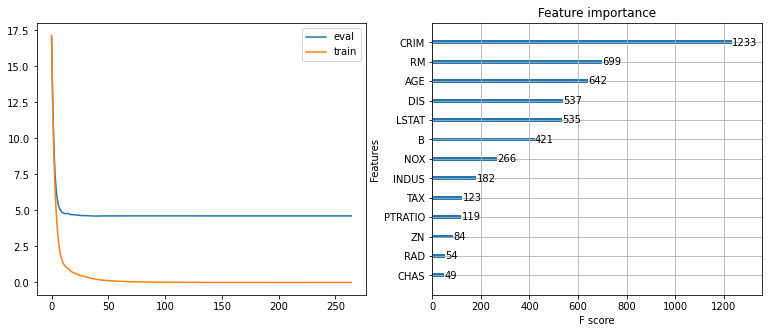

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn import metrics as met
import sklearn as skl
import numpy as np

dataset = load_boston()
x = dataset.data
t = dataset.target

x_train, x_test, t_train, t_test = skl.model_selection.train_test_split(x, t, test_size=0.2, random_state=0)

dtrain = xgb.DMatrix(x_train, label=t_train, feature_names=dataset.feature_names)
dtest = xgb.DMatrix(x_test, label=t_test, feature_names=dataset.feature_names)
# 変数名マッチしてないと怒られる

param = {}
param['eta'] = 0.3
param['gamma'] = 0
param['max_depth'] = 6
# max_depthだけ分岐を許す

param['min_child_weight'] = 1
param['subsample'] = 1
param['colsample_bytree'] = 1

param['objective'] = 'reg:squarederror'
param['eval_metric'] = 'rmse'
# default

num_round = 10000
evals = [(dtest, 'eval'),(dtrain, 'train')]
# early_stoppingのためのevaluationはtrainデータでやるみたい。evalデータは値を見せるだけ。
evals_result = {}

bst = xgb.train(param, dtrain, num_boost_round=num_round, evals=evals, evals_result=evals_result, early_stopping_rounds=100)
train_pred = bst.predict(dtrain, ntree_limit=bst.best_ntree_limit)
test_pred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

print('train_RMSE_score_is_{:.8f}, test_RMSE_score_is_{:.8f}'.format(np.sqrt(met.mean_squared_error(t_train, train_pred)), np.sqrt(met.mean_squared_error(t_test, test_pred))))
# 0.00116996, 4.62175620,  当然だがeval_metricが出してくる値と同じ
print('train_R2_score_is_{:.4f}, test_R2_score_is_{:.4f}'.format(met.r2_score(t_train, train_pred), met.r2_score(t_test, test_pred)))
# 1.0000, 0.7377 かなりoverfitting?
print('Best Score:{:.4f}, Iteration:{:d}, Ntree_Limit:{:d}'.format(bst.best_score, bst.best_iteration, bst.best_ntree_limit))
# Best Score:0.0012, Iteration:165, Ntree_Limit:166


plt.rcParams['figure.facecolor'] = 'white'

fig = plt.figure(figsize=(13, 5))
ax1 = plt.subplot(121)
ax1 = plt.plot(evals_result['eval']['rmse'], label = 'eval')
ax1 = plt.plot(evals_result['train']['rmse'], label = 'train')
plt.legend()
ax2 = plt.subplot(122)
ax2 = xgb.plot_importance(bst, ax=ax2)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


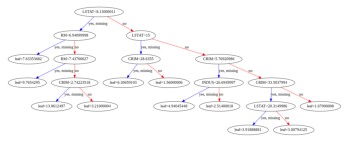

In [ ]:
xgb.plot_tree(bst, num_trees=0)

# 国勢調査

In [1]:
# ライブラリの読み込み
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn import metrics as met

from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
# データの読み込み
DATA = '/content/drive/MyDrive/data.csv'
df = pd.read_csv(DATA)

In [3]:
print(df.dtypes)

age                               float64
fnlwgt                            float64
education-num                     float64
capital-gain                      float64
capital-loss                      float64
                                   ...   
native-country_Trinadad&Tobago      int64
native-country_United-States        int64
native-country_Vietnam              int64
native-country_Yugoslavia           int64
Y                                   int64
Length: 108, dtype: object


In [4]:
# 分類するクラスの種類と数を確認
df['Y'].value_counts()

1    12288
0     3992
Name: Y, dtype: int64

In [5]:
# 重要度の高い上位３つの特徴量だけを学習に用いる。,'hours-per-week':df['hours-per-week']除く
df_1 = pd.DataFrame({ 'capital-gain' :df['capital-gain'], 'fnlwgt' :df['fnlwgt'],'age' :df['age'],'Y' :df['Y']})
df_1

,capital-gain,fnlwgt,age,Y
0,-0.147423,1.182326,3.759317,1
1,-0.147423,-1.097183,0.540986,1
2,-0.147423,-1.168326,-0.117309,0
3,-0.147423,-0.429370,0.467842,1
4,-0.147423,0.791181,0.102123,0
...,...,...,...,...
16275,-0.147423,-1.015991,0.248411,1
16276,-0.147423,0.316108,1.491857,1
16277,-0.147423,-0.453357,0.248411,1
16278,-0.147423,-0.674452,-1.433899,1


In [6]:
# 機械学習のモデルを作成するトレーニング用と評価用の2種類に分割する
train_x = df_1.drop(['Y'],axis=1) #　説明変数のみにする
train_y = df_1['Y'] # 正解クラス
(train_x,test_x,train_y,test_y) = train_test_split(train_x,train_y,test_size = 0.3,random_state = 42)
# 訓練用の説明変数と正解クラス、評価用の説明変数と正解クラスに分割 

In [7]:
# mod3 = xgb.XGBRegressor(max_depth = 6, learning_rate = 0.1, n_estimators=10, objective='reg:squarederror', gamma=0, min_child_weight=1, subsample=1, colsample_bytree=1)
mod3 = xgb.XGBClassifier(max_depth=6, learning_rate=0.1, n_estimators=10, objective='binary:logistic',gamma=0, min_child_weight=1, subsample=1, colsample_bytree=1, random_state=42)
# モデルを作成。xgb.trainにおけるparamの部分

params3 = {'max_depth': [8, 7, 6, 5, 4, 3], 'learning_rate': [0.1, 0.2, 0.3], 'gamma': [0.1, 0.2, 0.3], 'min_child_weight': [0.8, 1, 1.2], 'subsample': [1, 0.9, 0.8], 'colsample_bytree': [1, 0.9, 0.8]}
gscv3 = GridSearchCV(mod3, params3, cv = 5, refit=True,  scoring='accuracy', verbose = 1, n_jobs=-1)
# gscvをこれからやるよっていう宣言だけ。グリッドサーチは.fitで実行される。
# n_jobs=-1にするとCPU100%で全コア並列計算。とても速い。

evallist = [(train_x, train_y)]
gscv3.fit(train_x, train_y, eval_metric='logloss', eval_set=evallist, early_stopping_rounds=100)
# 全データに対して学習を行う。evallistの値に対してloglossで評価を行い、100round後も変化がなければ終了。

print(gscv3.best_params_)
# {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 7, 'min_child_weight': 0.8, 'subsample': 0.8}

x_train, x_test, t_train, t_test = train_test_split(train_x, train_y, test_size=0.2, random_state=0)

train_pred = gscv3.predict(x_train)
test_pred = gscv3.predict(x_test)

print('train_accuracy_score_is_{:.4f}, test_accuracy_score_is_{:.4f}'.format(met.accuracy_score(t_train, train_pred), met.accuracy_score(t_test, test_pred)))
# 0.8042, 0.8018
print('train_f1_score_is_{:.4f}, test_f1_score_is_{:.4f}'.format(met.f1_score(t_train, train_pred), met.f1_score(t_test, test_pred)))
# 0.8849, 0.8834

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits
[0]	validation_0-logloss:0.584094
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.525656
[2]	validation_0-logloss:0.490829
[3]	validation_0-logloss:0.467722
[4]	validation_0-logloss:0.45382
[5]	validation_0-logloss:0.444708
[6]	validation_0-logloss:0.435609
[7]	validation_0-logloss:0.428054
[8]	validation_0-logloss:0.424604
[9]	validation_0-logloss:0.422034
{'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 7, 'min_child_weight': 0.8, 'subsample': 0.8}
train_accuracy_score_is_0.8042, test_accuracy_score_is_0.8018
train_f1_score_is_0.8849, test_f1_score_is_0.8834


In [8]:
print('train_accuracy_score_is_{:.4f}, test_accuracy_score_is_{:.4f}'.format(met.accuracy_score(t_train, train_pred), met.accuracy_score(t_test, test_pred)))
# 0.8042, 0.8018
print('train_f1_score_is_{:.4f}, test_f1_score_is_{:.4f}'.format(met.f1_score(t_train, train_pred), met.f1_score(t_test, test_pred)))
# 0.8849, 0.8834

train_accuracy_score_is_0.8042, test_accuracy_score_is_0.8018
train_f1_score_is_0.8849, test_f1_score_is_0.8834


In [11]:
# データの読み込み 予測したい本番データ
test = '/content/drive/MyDrive/test_data.csv'
values = pd.read_csv(test)

In [12]:
print(values)

          id       age  ...  native-country_Vietnam  native-country_Yugoslavia
0          0 -0.629316  ...                       0                          0
1          1  0.028979  ...                       0                          0
2          2 -0.775604  ...                       0                          0
3          3  0.833562  ...                       0                          0
4          4  1.052993  ...                       0                          0
...      ...       ...  ...                     ...                        ...
16276  32549  1.491857  ...                       0                          0
16277  32556 -1.287611  ...                       0                          0
16278  32558  1.491857  ...                       0                          0
16279  32559  1.345569  ...                       0                          0
16280  32560 -0.848748  ...                       0                          0

[16281 rows x 109 columns]


In [13]:
# 欠損データの確認
values.isnull().sum()

id                                0
age                               0
fnlwgt                            0
education-num                     0
capital-gain                      0
                                 ..
native-country_Thailand           0
native-country_Trinadad&Tobago    0
native-country_United-States      0
native-country_Vietnam            0
native-country_Yugoslavia         0
Length: 109, dtype: int64

In [15]:
# 重要度の高い上位３つの特徴量だけを学習に用いる。,'hours-per-week':df['hours-per-week']除く
test = pd.DataFrame({ 'capital-gain' :values['capital-gain'], 'fnlwgt' :values['fnlwgt'],'age' :values['age']})
test

,capital-gain,fnlwgt,age
0,-0.147423,-0.783532,-0.629316
1,-0.147423,-1.079335,0.028979
2,-0.147423,-0.387572,-0.775604
3,-0.147423,0.822463,0.833562
4,-0.147423,-0.117539,1.052993
...,...,...,...
16276,-0.147423,1.735626,1.491857
16277,-0.147423,-0.338968,-1.287611
16278,-0.147423,-0.136207,1.491857
16279,-0.147423,1.724852,1.345569


In [16]:
clf = xgb.XGBClassifier(max_depth=7, learning_rate=0.3, n_estimators=10, objective='binary:logistic', eval_metric='logloss', gamma=0.2, min_child_weight=0.8, subsample=0.8, colsample_bytree=0.9, random_state=42)
# {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 7, 'min_child_weight': 0.8, 'subsample': 0.8}
# 学習
clf.fit(train_x, train_y)

Y_pred = clf.predict(test)
print(Y_pred)



[1 1 1 ... 1 1 1]


In [18]:
y = pd.DataFrame()
y['Y'] = Y_pred

In [19]:
print(y)

       Y
0      1
1      1
2      1
3      1
4      1
...   ..
16276  1
16277  1
16278  1
16279  1
16280  1

[16281 rows x 1 columns]


In [20]:
y['Y'].replace([1,0],['<=50K','>50K'],inplace=True)
y['Y']

0        <=50K
1        <=50K
2        <=50K
3        <=50K
4        <=50K
         ...  
16276    <=50K
16277    <=50K
16278    <=50K
16279    <=50K
16280    <=50K
Name: Y, Length: 16281, dtype: object

In [25]:
# データの読み込み
x = '/content/drive/MyDrive/test_data.csv'
x = pd.read_csv(x)

In [26]:
x

,id,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_?,...,native-country_Canada,native-country_China,native-country_Columbia,native-country_Cuba,native-country_Dominican-Republic,native-country_Ecuador,native-country_El-Salvador,native-country_England,native-country_France,native-country_Germany,native-country_Greece,native-country_Guatemala,native-country_Haiti,native-country_Holand-Netherlands,native-country_Honduras,native-country_Hong,native-country_Hungary,native-country_India,native-country_Iran,native-country_Ireland,native-country_Italy,native-country_Jamaica,native-country_Japan,native-country_Laos,native-country_Mexico,native-country_Nicaragua,native-country_Outlying-US(Guam-USVI-etc),native-country_Peru,native-country_Philippines,native-country_Poland,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,0,-0.629316,-0.783532,-0.034836,-0.147423,-0.217342,1.266311,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,0.028979,-1.079335,-0.034836,-0.147423,-0.217342,1.591215,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,2,-0.775604,-0.387572,-0.034836,-0.147423,-0.217342,-2.713760,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,3,0.833562,0.822463,1.132101,-0.147423,-0.217342,-0.033304,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,4,1.052993,-0.117539,1.132101,-0.147423,-0.217342,-0.033304,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,32549,1.491857,1.735626,1.132101,-0.147423,-0.217342,-0.033304,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
16277,32556,-1.287611,-0.338968,-0.034836,-0.147423,-0.217342,-0.033304,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
16278,32558,1.491857,-0.136207,-0.034836,-0.147423,-0.217342,-2.145178,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16279,32559,1.345569,1.724852,-0.423815,-0.147423,5.354678,-0.033304,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [27]:
x = x['id']

In [28]:
x

0            0
1            1
2            2
3            3
4            4
         ...  
16276    32549
16277    32556
16278    32558
16279    32559
16280    32560
Name: id, Length: 16281, dtype: int64

In [29]:
y = pd.DataFrame({'id':x, 'Y':y['Y']})

In [31]:
y

,id,Y
0,0,<=50K
1,1,<=50K
2,2,<=50K
3,3,<=50K
4,4,<=50K
...,...,...
16276,32549,<=50K
16277,32556,<=50K
16278,32558,<=50K
16279,32559,<=50K


In [30]:
y.to_csv('/content/drive/MyDrive/submit.csv', header=False, index=False)

In [32]:
Y = pd.read_csv('/content/drive/MyDrive/submit.csv')

In [33]:
Y

,0,<=50K
0,1,<=50K
1,2,<=50K
2,3,<=50K
3,4,<=50K
4,6,<=50K
...,...,...
16275,32549,<=50K
16276,32556,<=50K
16277,32558,<=50K
16278,32559,<=50K
